In [3]:
%cd ..

/home/sasha/effective-inference


## Modules

In [4]:
from typing import Tuple, List, Dict, Optional, Union
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from datasets.dataset_dict import DatasetDict

from utils.prepare_dataset import load_datasets, cut_datasets
from utils.config import ConfigWrapper
import yaml

In [11]:
with open('config.yaml', "r") as f:
        config = ConfigWrapper(yaml.load(f, Loader=yaml.FullLoader))
results_metric = 'accuracy'

In [7]:
f = """data:
    data_path: '/home/sasha/effective-inference/data/gpt2'

    model_save_pattern: '30_09'
"""

config = ConfigWrapper(yaml.load(f, Loader=yaml.FullLoader))
results_metric = 'perplexity'

In [23]:
baseline[(baseline['model_name']=='Original') & (baseline['dataset_name']=='wnli') ]

,model_name,dataset_name,layers,accuracy,f1
135,Original,wnli,8,0.352113,0.354696
137,Original,wnli,8,0.352113,0.354696
140,Original,wnli,8,0.352113,0.354696
149,Original,wnli,9,0.352113,0.354696
158,Original,wnli,10,0.352113,0.354696
167,Original,wnli,11,0.352113,0.354696


In [29]:
list(baseline[(baseline['model_name']=='Original')&(baseline['dataset_name']=='wnli')]['accuracy'])[0]

0.352112676056338

In [38]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interactive_output
import plotly.graph_objs as go
from IPython.display import display
import plotly.figure_factory as ff


baseline = pd.read_csv(f'{config.data.data_path}/baseline_first_try.csv', index_col = [0])
baseline = baseline[baseline['layers'].str.contains(',') == False]

baseline['layers'] = baseline['layers'].apply(lambda x: int(str(x)[1:-1])) 

# Assuming 'results' is your DataFrame
# Function to plot the first graph
def plot_graph1(dataset_name, linear_selector):
    results = pd.read_csv(f'{config.data.data_path}/results_{dataset_name}.csv', index_col = [0])
    metrics = pd.read_csv(f'{config.data.data_path}/metrics_{dataset_name}.csv', index_col = [0])
    results = results[results['layers'].str.contains(',') == False]
    results['layers'] = results['layers'].apply(lambda x: int(str(x)[1:-1])) 
    data = []
    dataset_name = dataset_name if dataset_name!= 'sst' else 'sst2'
    for name, group_data in baseline[(baseline['dataset_name']==dataset_name)&(baseline['model_name']!='Original')].sort_values(by='layers').groupby('model_name'):
        layers = group_data['layers']
        accuracy = group_data[results_metric]
        data.append(go.Scatter(x=layers, y=accuracy, name=name))
    layers = list(range(12))
    accuracy = list(baseline[(baseline['model_name']=='Original')&(baseline['dataset_name']==dataset_name)][results_metric])[0]
    data.append(go.Scatter(x=layers, y=[accuracy for i in layers], name='Original'))
    if linear_selector == 'On':
        for name, group_data in results[results['dataset_name']==dataset_name].sort_values(by='layers').groupby('dataset_name'):
            layers = group_data['layers']
            accuracy = group_data[results_metric]
            data.append(go.Scatter(x=layers, y=accuracy, name='Linear'))
    fig = go.Figure(data=data)
    fig.update_layout(xaxis_title='Layers', yaxis_title=results_metric)
    fig.update_layout(title='Accuracy vs. Layers for Different Dataset Names')
    fig.show()

# Function to plot the second graph
def plot_graph2(dataset_name, metric):
    results = pd.read_csv(f'{config.data.data_path}/results_{dataset_name}.csv', index_col = [0])
    metrics = pd.read_csv(f'{config.data.data_path}/metrics_{dataset_name}.csv', index_col = [0])
    results = results[results['layers'].str.contains(',') == False]
    results['layers'] = results['layers'].apply(lambda x: int(str(x)[1:-1])) 
    
    filtered_df = metrics.sort_values(by='layer')
    fig = px.line(filtered_df, x='layer', y=metric, color='dataset_name', markers=True,
                  title=f'{metric} vs. Layers for Dataset {dataset_name}',
                  labels={'layer': 'Layers', metric: metric})
    fig.show()


# Define interactive widgets
dataset_selector = widgets.Dropdown(
    options=['sst', 'wnli'],
    value='wnli',
    description='Dataset:'
)

metric_selector = widgets.Dropdown(
    options=['r2', 'mse', 'explained_variance_score', 'max_error', 'mean_absolute_percentage_error'],
    value='r2',
    description='Metric:'
)

linear_selector = widgets.Dropdown(
    options=['On', 'Off'],
    value='On',
    description='Show Linear:'
)

# Create an interactive function to update both graphs
def update_plots(dataset_name, metric, linear):    
    if linear == 'On':
        plot_graph2(dataset_name, metric)
    
    plot_graph1(dataset_name, linear)
    # plot3(dataset_name, metric)


# Use interactive_output to link widgets to the function
out = interactive_output(update_plots, {'dataset_name': dataset_selector, 'metric': metric_selector, 'linear': linear_selector})

# Display the widgets and both graphs
display(widgets.HBox([dataset_selector, metric_selector, linear_selector]))
display(out)


Output()

In [49]:
from sklearn.metrics import r2_score, mean_squared_error
import psutil

final_models = {}
final_coefs= {}
for layer in tqdm([11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]):
    final_models[layer] = []
    print(f'Layer {layer}')
    for i in range(5):
        with h5py.File(f'notebooks/data/{dataset_name}/layer_{layer}/{i}.hdf5', 'r') as f:
            X_train = f['X_train'][()][:,:768]
            y_train = f['y_train'][()]
            X_test = f['X_test'][()][:,:768]
            y_test = f['y_test'][()]    
        print(f'Train: {X_train.shape}, Test: {len(X_test)}')
        model = learn_linear(Ridge(), id_scaler, id_scaler, X_train, y_train, X_test, y_test)
        preds_scaled = model.predict(X_test)
        preds = id_scaler(preds_scaled)
        score_test = r2_score(y_test, preds)
        print(score_test)
        final_models[layer].append(model)
    final_coefs[layer] = model.coef_

  0%|                                                                 | 0/12 [00:00<?, ?it/s]

Layer 11
Train: (179237, 768), Test: 9434
Y train mean scaled: -6.1578965 , Y test mean scaled: -6.2634125
0.3786605505087931
Train: (199243, 768), Test: 10486
Y train mean scaled: -6.1604867 , Y test mean scaled: -5.525296
0.3315820647204615
Train: (213749, 768), Test: 11250
Y train mean scaled: -6.0665736 , Y test mean scaled: -6.140334
0.3609101391846218
Train: (277808, 768), Test: 14621
Y train mean scaled: -6.006435 , Y test mean scaled: -6.1426926
0.43880949251631296
Train: (214840, 768), Test: 11307
Y train mean scaled: -6.037857 , Y test mean scaled: -6.1589155


  8%|████▊                                                    | 1/12 [00:34<06:16, 34.23s/it]

0.35978252328705007
Layer 10
Train: (217785, 768), Test: 11462
Y train mean scaled: -6.4428806 , Y test mean scaled: -6.7527204
0.27915027374117596
Train: (238955, 768), Test: 12577
Y train mean scaled: -6.5305724 , Y test mean scaled: -6.365891
0.2430760222758669
Train: (276695, 768), Test: 14563
Y train mean scaled: -6.521085 , Y test mean scaled: -5.989593
0.278680319219503
Train: (235964, 768), Test: 12419
Y train mean scaled: -6.638694 , Y test mean scaled: -6.811783
0.2737397329929011
Train: (264796, 768), Test: 13937
Y train mean scaled: -6.6633177 , Y test mean scaled: -6.2943664


 17%|█████████▌                                               | 2/12 [01:20<06:50, 41.04s/it]

0.3941514879778877
Layer 9
Train: (182245, 768), Test: 9592
Y train mean scaled: -6.4518476 , Y test mean scaled: -6.2638755
0.30569060267054393
Train: (235026, 768), Test: 12370
Y train mean scaled: -6.298654 , Y test mean scaled: -6.3035607
0.11875423899341597
Train: (209719, 768), Test: 11038
Y train mean scaled: -6.2896285 , Y test mean scaled: -6.1863465
0.2815731465629717
Train: (186049, 768), Test: 9792
Y train mean scaled: -6.1906633 , Y test mean scaled: -6.266952
0.28835444010680833
Train: (213284, 768), Test: 11226
Y train mean scaled: -6.3013754 , Y test mean scaled: -6.191964


 25%|██████████████▎                                          | 3/12 [01:59<06:01, 40.15s/it]

0.25966553479299015
Layer 8
Train: (221242, 768), Test: 11644
Y train mean scaled: -6.518686 , Y test mean scaled: -6.6439466
0.12117953907879264
Train: (243522, 768), Test: 12817
Y train mean scaled: -6.550937 , Y test mean scaled: -6.003183
0.23112322200040525
Train: (156122, 768), Test: 8217
Y train mean scaled: -6.5783033 , Y test mean scaled: -6.400243
0.0162172036409578
Train: (196903, 768), Test: 10363
Y train mean scaled: -6.5808277 , Y test mean scaled: -6.550075
0.10886663375881755
Train: (128886, 768), Test: 6784
Y train mean scaled: -6.4751105 , Y test mean scaled: -5.5911617


 33%|███████████████████                                      | 4/12 [02:33<05:03, 37.99s/it]

-0.3317436393090385
Layer 7
Train: (260326, 768), Test: 13701
Y train mean scaled: -7.070214 , Y test mean scaled: -8.169417
0.11653333742025118
Train: (220788, 768), Test: 11620
Y train mean scaled: -7.146482 , Y test mean scaled: -7.4065895
0.033842406208646425
Train: (257095, 768), Test: 13531
Y train mean scaled: -6.9103785 , Y test mean scaled: -7.7638535
0.10519998694916122
Train: (216050, 768), Test: 11371
Y train mean scaled: -6.998885 , Y test mean scaled: -7.6898108
0.17337010573533207
Train: (213523, 768), Test: 11238
Y train mean scaled: -6.919623 , Y test mean scaled: -7.385061


 42%|███████████████████████▊                                 | 5/12 [03:17<04:41, 40.18s/it]

0.07700856901859343
Layer 6
Train: (246583, 768), Test: 12978
Y train mean scaled: -6.9517536 , Y test mean scaled: -7.0349607
0.18817215483388428
Train: (285703, 768), Test: 15037
Y train mean scaled: -7.039995 , Y test mean scaled: -7.6358056
0.1775497543849195
Train: (165715, 768), Test: 8722
Y train mean scaled: -6.9370084 , Y test mean scaled: -7.0364294
0.15706736441430125
Train: (172420, 768), Test: 9075
Y train mean scaled: -7.1216164 , Y test mean scaled: -7.060547
0.1634512296786138
Train: (149901, 768), Test: 7890
Y train mean scaled: -6.9669046 , Y test mean scaled: -7.2712173


 50%|████████████████████████████▌                            | 6/12 [03:55<03:55, 39.33s/it]

0.1597831708910017
Layer 5
Train: (225025, 768), Test: 11843
Y train mean scaled: -7.009394 , Y test mean scaled: -7.025103
0.15095023130773644
Train: (180737, 768), Test: 9512
Y train mean scaled: -6.931515 , Y test mean scaled: -7.54635
0.15752216092978777
Train: (190442, 768), Test: 10023
Y train mean scaled: -7.0926166 , Y test mean scaled: -6.3380527
0.10280337880924273
Train: (166911, 768), Test: 8785
Y train mean scaled: -6.9531384 , Y test mean scaled: -6.607244
0.009000899392390793
Train: (189150, 768), Test: 9955
Y train mean scaled: -7.0320315 , Y test mean scaled: -6.6471334


 58%|█████████████████████████████████▎                       | 7/12 [04:31<03:11, 38.33s/it]

0.09440191822961597
Layer 4
Train: (275109, 768), Test: 14479
Y train mean scaled: -6.4178677 , Y test mean scaled: -6.757731
0.1248168000117279
Train: (171354, 768), Test: 9019
Y train mean scaled: -6.480999 , Y test mean scaled: -6.003023
-0.8078649735317169
Train: (304090, 768), Test: 16005
Y train mean scaled: -6.4050846 , Y test mean scaled: -6.6637254
0.17067359200652243
Train: (219412, 768), Test: 11548
Y train mean scaled: -6.265139 , Y test mean scaled: -7.0308867
-0.02316609884833798
Train: (179647, 768), Test: 9455
Y train mean scaled: -6.388902 , Y test mean scaled: -6.5418086


 67%|██████████████████████████████████████                   | 8/12 [05:14<02:38, 39.72s/it]

0.18800675846603776
Layer 3
Train: (137931, 768), Test: 7260
Y train mean scaled: -6.2949314 , Y test mean scaled: -6.54586
0.10840922523517182
Train: (174905, 768), Test: 9206
Y train mean scaled: -6.2840333 , Y test mean scaled: -6.9218183
0.10698068812082773
Train: (194816, 768), Test: 10253
Y train mean scaled: -6.3242054 , Y test mean scaled: -6.657123
0.07730348362111616
Train: (252977, 768), Test: 13315
Y train mean scaled: -6.429841 , Y test mean scaled: -6.4614825
-0.35985682927324114
Train: (140021, 768), Test: 7370
Y train mean scaled: -6.25741 , Y test mean scaled: -6.5367856


 75%|██████████████████████████████████████████▊              | 9/12 [05:48<01:54, 38.05s/it]

0.10650550897774114
Layer 2
Train: (276925, 768), Test: 14575
Y train mean scaled: -8.313403 , Y test mean scaled: -8.315569
-0.09061859885348178
Train: (213316, 768), Test: 11227
Y train mean scaled: -8.277937 , Y test mean scaled: -7.9477468
-0.0709433737763061
Train: (203594, 768), Test: 10715
Y train mean scaled: -8.23842 , Y test mean scaled: -7.347701
-0.743408109568636
Train: (241582, 768), Test: 12715
Y train mean scaled: -8.325938 , Y test mean scaled: -7.2572145
-5.1915339046298925
Train: (153595, 768), Test: 8084
Y train mean scaled: -8.193428 , Y test mean scaled: -7.8104696


 83%|██████████████████████████████████████████████▋         | 10/12 [06:29<01:17, 39.00s/it]

-0.5838576231397143
Layer 1
Train: (186343, 768), Test: 9808
Y train mean scaled: -6.1787515 , Y test mean scaled: -6.319547
0.022652104233098713
Train: (271740, 768), Test: 14302
Y train mean scaled: -6.2045674 , Y test mean scaled: -6.298799
0.024741700847565662
Train: (170729, 768), Test: 8986
Y train mean scaled: -6.290158 , Y test mean scaled: -6.250949
0.03446760213869404
Train: (131560, 768), Test: 6924
Y train mean scaled: -6.074579 , Y test mean scaled: -6.16599
0.028091426762170135
Train: (190930, 768), Test: 10049
Y train mean scaled: -6.1945896 , Y test mean scaled: -6.219161


 92%|███████████████████████████████████████████████████▎    | 11/12 [07:06<00:38, 38.21s/it]

-0.03351467544524067
Layer 0
Train: (199391, 768), Test: 10494
Y train mean scaled: -5.14934 , Y test mean scaled: -5.295481
-0.0029779820107600496
Train: (196014, 768), Test: 10317
Y train mean scaled: -5.19817 , Y test mean scaled: -4.7565427
-0.03093726671489927
Train: (248230, 768), Test: 13065
Y train mean scaled: -5.181726 , Y test mean scaled: -4.8724885
-0.05781649388642651
Train: (224251, 768), Test: 11803
Y train mean scaled: -5.2411304 , Y test mean scaled: -5.2886014
-0.021582393671472744
Train: (204465, 768), Test: 10761
Y train mean scaled: -5.1642017 , Y test mean scaled: -5.385914


100%|████████████████████████████████████████████████████████| 12/12 [07:48<00:00, 39.04s/it]

-0.000280629012558542


In [52]:
import pandas as pd
# cols = ['dataset_name', 'dataset_id','layer', 'model_name', 'r2', 'mse', 'explained_variance_score', 'max_error', 
                                     # 'mean_absolute_percentage_error']
# metrics_emb_to = pd.DataFrame([], columns = cols)
metrics_emb_to.head()

,dataset_name,dataset_id,layer,model_name,r2,mse,explained_variance_score,max_error,mean_absolute_percentage_error
0,mrpc,0,0,Ridge(),-0.002978,3.296555,0.015527,10.067505,0.339986
1,mrpc,1,0,Ridge(),-0.030937,3.720509,-0.014454,10.314950,0.430235
2,mrpc,2,0,Ridge(),-0.057816,3.400772,-0.004348,10.320131,0.421811
3,mrpc,3,0,Ridge(),-0.021582,3.557836,-0.004248,8.900052,0.326921
4,mrpc,4,0,Ridge(),-0.000281,4.042217,0.014502,9.707900,0.310844


In [42]:
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_percentage_error
def check_metrics(model_list):   
    data = {i: '' for i in cols}
    data['dataset_name'] = list(dataset.keys())[0]
    for layer in tqdm(range(11)):
        data['layer'] = layer
        for i, model in enumerate(final_models[layer]):
            data['dataset_id'] = i
            data['model_name'] = str(model)
            with h5py.File(f'notebooks/data/{dataset_name}/layer_{layer}/{i}.hdf5', 'r') as f:
                X_train = f['X_train'][()][:,:768]
                y_train = f['y_train'][()]
                X_test = f['X_test'][()][:,:768]
                y_test = f['y_test'][()]        
            preds_scaled = model.predict(X_test)
            preds = id_scaler(preds_scaled)
            data['r2'] = r2_score(y_test, preds)
            data['mse'] = mean_squared_error(y_test, preds)
            data['explained_variance_score'] = explained_variance_score(y_test, preds)
            data['max_error'] = max_error(y_test, preds)
            data['mean_absolute_percentage_error'] = mean_absolute_percentage_error(y_test, preds)
            data['model'] = model
            metrics_emb_to.loc[len(metrics_emb_to)] = data

In [105]:
check_metrics(final_models)

100%|███████████████████████████████████████████| 11/11 [04:04<00:00, 22.19s/it]


In [54]:
metrics_emb_to['layer'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [35]:
import datetime
# metrics_emb_to.to_csv(f'/home/sasha/effective-inference/linear_metrics_emb_to_{datetime.date.today()}.csv')
metrics_emb_to = pd.read_csv(f'linear_metrics_emb_to_2023-09-24.csv', index_col = [0])

### Evaluate Results

In [56]:
# cols = ['dataset_name', 'dataset_id', 'layers', 'accuracy', 'f1', 'model']
# results = pd.DataFrame([], columns = cols)
data = {i: '' for i in cols}
data['model'] = 'LinearClassifierBertAttention'
for i in range(5):
    data['dataset_id'] = i
    for layer in tqdm(range(5, 12)):
        layers = [layer]
        print(f'Layers: {layers}')
        data['layers'] = layer
        coefs = {j : final_models[j][i].coef_ for j in range(layer, 12)}
        custom_model = BertWrapperLin(initial_model, LinearClassifierBertAttention, coefs, layers)
        check_results(custom_model, initial_model)

  0%|                                                                  | 0/7 [00:00<?, ?it/s]

Layers: [5]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:20<00:00,  9.88it/s]


Validation evaluation:
Weighted F1:  0.7220754122134997 , Accuracy:  0.735
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:14<00:00, 14.12it/s]


Validation evaluation:
Weighted F1:  0.6589774436090226 , Accuracy:  0.66
-------------------------------
WIC / wic



 14%|████████▏                                                | 1/7 [02:17<13:46, 137.80s/it]

Validation evaluation:
Weighted F1:  0.5096073717948717 , Accuracy:  0.51
-------------------------------
Layers: [6]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:19<00:00, 10.12it/s]


Validation evaluation:
Weighted F1:  0.7011348684210525 , Accuracy:  0.73
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:13<00:00, 15.12it/s]


Validation evaluation:
Weighted F1:  0.6849763744093603 , Accuracy:  0.685
-------------------------------
WIC / wic



 29%|████████████████▎                                        | 2/7 [04:37<11:34, 138.87s/it]

Validation evaluation:
Weighted F1:  0.5444870863498585 , Accuracy:  0.545
-------------------------------
Layers: [7]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:20<00:00,  9.90it/s]


Validation evaluation:
Weighted F1:  0.6712989346682069 , Accuracy:  0.69
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:13<00:00, 14.47it/s]


Validation evaluation:
Weighted F1:  0.67768115942029 , Accuracy:  0.68
-------------------------------
WIC / wic



 43%|████████████████████████▍                                | 3/7 [06:52<09:07, 137.00s/it]

Validation evaluation:
Weighted F1:  0.56 , Accuracy:  0.56
-------------------------------
Layers: [8]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:17<00:00, 11.66it/s]


Validation evaluation:
Weighted F1:  0.6405684678500212 , Accuracy:  0.665
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:11<00:00, 16.83it/s]


Validation evaluation:
Weighted F1:  0.724979374484362 , Accuracy:  0.725
-------------------------------
WIC / wic



 57%|████████████████████████████████▌                        | 4/7 [09:06<06:48, 136.00s/it]

Validation evaluation:
Weighted F1:  0.5749468417761101 , Accuracy:  0.575
-------------------------------
Layers: [9]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:20<00:00,  9.89it/s]


Validation evaluation:
Weighted F1:  0.6998338870431895 , Accuracy:  0.725
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:13<00:00, 14.95it/s]


Validation evaluation:
Weighted F1:  0.7646291239760515 , Accuracy:  0.765
-------------------------------
WIC / wic



 71%|████████████████████████████████████████▋                | 5/7 [11:24<04:33, 136.64s/it]

Validation evaluation:
Weighted F1:  0.5820161961704382 , Accuracy:  0.585
-------------------------------
Layers: [10]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:19<00:00, 10.02it/s]


Validation evaluation:
Weighted F1:  0.6794178794178793 , Accuracy:  0.7
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:15<00:00, 12.68it/s]


Validation evaluation:
Weighted F1:  0.7489462063428343 , Accuracy:  0.75
-------------------------------
WIC / wic



 86%|████████████████████████████████████████████████▊        | 6/7 [13:46<02:18, 138.51s/it]

Validation evaluation:
Weighted F1:  0.5047398062626718 , Accuracy:  0.505
-------------------------------
Layers: [11]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:17<00:00, 11.56it/s]


Validation evaluation:
Weighted F1:  0.6473596673596673 , Accuracy:  0.67
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:13<00:00, 14.80it/s]


Validation evaluation:
Weighted F1:  0.7445978824059474 , Accuracy:  0.745
-------------------------------
WIC / wic



100%|█████████████████████████████████████████████████████████| 7/7 [16:01<00:00, 137.31s/it]


Validation evaluation:
Weighted F1:  0.5637222264065678 , Accuracy:  0.565
-------------------------------


  0%|                                                                  | 0/7 [00:00<?, ?it/s]

Layers: [5]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:19<00:00, 10.07it/s]


Validation evaluation:
Weighted F1:  0.720064112787471 , Accuracy:  0.735
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:13<00:00, 15.17it/s]


Validation evaluation:
Weighted F1:  0.6793589743589743 , Accuracy:  0.68
-------------------------------
WIC / wic



 14%|████████▏                                                | 1/7 [02:17<13:43, 137.22s/it]

Validation evaluation:
Weighted F1:  0.5092631578947369 , Accuracy:  0.51
-------------------------------
Layers: [6]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:17<00:00, 11.68it/s]


Validation evaluation:
Weighted F1:  0.6970518185839203 , Accuracy:  0.725
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:14<00:00, 13.70it/s]


Validation evaluation:
Weighted F1:  0.6548705958840739 , Accuracy:  0.655
-------------------------------
WIC / wic



 29%|████████████████▎                                        | 2/7 [04:34<11:24, 136.98s/it]

Validation evaluation:
Weighted F1:  0.5393082706766917 , Accuracy:  0.54
-------------------------------
Layers: [7]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:17<00:00, 11.41it/s]


Validation evaluation:
Weighted F1:  0.658045738045738 , Accuracy:  0.68
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:13<00:00, 14.80it/s]


Validation evaluation:
Weighted F1:  0.6972779514063919 , Accuracy:  0.7
-------------------------------
WIC / wic



 43%|████████████████████████▍                                | 3/7 [06:41<08:50, 132.69s/it]

Validation evaluation:
Weighted F1:  0.5347555755800856 , Accuracy:  0.535
-------------------------------
Layers: [8]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:15<00:00, 12.90it/s]


Validation evaluation:
Weighted F1:  0.6473596673596673 , Accuracy:  0.67
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:14<00:00, 13.66it/s]


Validation evaluation:
Weighted F1:  0.7149786244656116 , Accuracy:  0.715
-------------------------------
WIC / wic



 57%|████████████████████████████████▌                        | 4/7 [08:54<06:38, 132.89s/it]

Validation evaluation:
Weighted F1:  0.5750318821734891 , Accuracy:  0.575
-------------------------------
Layers: [9]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:17<00:00, 11.45it/s]


Validation evaluation:
Weighted F1:  0.6970518185839203 , Accuracy:  0.725
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:13<00:00, 15.29it/s]


Validation evaluation:
Weighted F1:  0.7597115384615385 , Accuracy:  0.76
-------------------------------
WIC / wic



 71%|████████████████████████████████████████▋                | 5/7 [11:11<04:28, 134.32s/it]

Validation evaluation:
Weighted F1:  0.5933199245757386 , Accuracy:  0.595
-------------------------------
Layers: [10]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:20<00:00,  9.84it/s]


Validation evaluation:
Weighted F1:  0.6794178794178793 , Accuracy:  0.7
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:14<00:00, 13.58it/s]


Validation evaluation:
Weighted F1:  0.7485931062204803 , Accuracy:  0.75
-------------------------------
WIC / wic



 86%|████████████████████████████████████████████████▊        | 6/7 [13:38<02:18, 138.67s/it]

Validation evaluation:
Weighted F1:  0.5096073717948717 , Accuracy:  0.51
-------------------------------
Layers: [11]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:19<00:00, 10.18it/s]


Validation evaluation:
Weighted F1:  0.6473596673596673 , Accuracy:  0.67
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:15<00:00, 13.21it/s]


Validation evaluation:
Weighted F1:  0.7396877189470524 , Accuracy:  0.74
-------------------------------
WIC / wic



100%|█████████████████████████████████████████████████████████| 7/7 [15:51<00:00, 135.93s/it]


Validation evaluation:
Weighted F1:  0.5637222264065678 , Accuracy:  0.565
-------------------------------


  0%|                                                                  | 0/7 [00:00<?, ?it/s]

Layers: [5]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:15<00:00, 13.07it/s]


Validation evaluation:
Weighted F1:  0.7095004944020924 , Accuracy:  0.725
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:13<00:00, 15.06it/s]


Validation evaluation:
Weighted F1:  0.6741939928354919 , Accuracy:  0.675
-------------------------------
WIC / wic



 14%|████████▏                                                | 1/7 [02:14<13:29, 134.93s/it]

Validation evaluation:
Weighted F1:  0.5444870863498585 , Accuracy:  0.545
-------------------------------
Layers: [6]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:19<00:00, 10.27it/s]


Validation evaluation:
Weighted F1:  0.7011348684210525 , Accuracy:  0.73
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:14<00:00, 13.41it/s]


Validation evaluation:
Weighted F1:  0.6562222222222224 , Accuracy:  0.66
-------------------------------
WIC / wic



 29%|████████████████▎                                        | 2/7 [04:31<11:19, 135.89s/it]

Validation evaluation:
Weighted F1:  0.5499999999999999 , Accuracy:  0.55
-------------------------------
Layers: [7]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:15<00:00, 12.92it/s]


Validation evaluation:
Weighted F1:  0.6620270667843482 , Accuracy:  0.685
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:11<00:00, 17.41it/s]


Validation evaluation:
Weighted F1:  0.6764444444444444 , Accuracy:  0.68
-------------------------------
WIC / wic



 43%|████████████████████████▍                                | 3/7 [06:40<08:51, 132.77s/it]

Validation evaluation:
Weighted F1:  0.5500450045004501 , Accuracy:  0.55
-------------------------------
Layers: [8]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:19<00:00, 10.13it/s]


Validation evaluation:
Weighted F1:  0.6405684678500212 , Accuracy:  0.665
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:14<00:00, 14.22it/s]


Validation evaluation:
Weighted F1:  0.7099999999999999 , Accuracy:  0.71
-------------------------------
WIC / wic



 57%|████████████████████████████████▌                        | 4/7 [08:59<06:45, 135.18s/it]

Validation evaluation:
Weighted F1:  0.5750318821734891 , Accuracy:  0.575
-------------------------------
Layers: [9]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:15<00:00, 12.89it/s]


Validation evaluation:
Weighted F1:  0.6889187556629417 , Accuracy:  0.715
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:14<00:00, 13.88it/s]


Validation evaluation:
Weighted F1:  0.7697235576923077 , Accuracy:  0.77
-------------------------------
WIC / wic



 71%|████████████████████████████████████████▋                | 5/7 [11:09<04:26, 133.47s/it]

Validation evaluation:
Weighted F1:  0.5880193236714976 , Accuracy:  0.59
-------------------------------
Layers: [10]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:18<00:00, 10.93it/s]


Validation evaluation:
Weighted F1:  0.6794178794178793 , Accuracy:  0.7
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:13<00:00, 15.04it/s]


Validation evaluation:
Weighted F1:  0.7634934003771212 , Accuracy:  0.765
-------------------------------
WIC / wic



 86%|████████████████████████████████████████████████▊        | 6/7 [13:30<02:15, 135.76s/it]

Validation evaluation:
Weighted F1:  0.5196153846153846 , Accuracy:  0.52
-------------------------------
Layers: [11]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:16<00:00, 12.11it/s]


Validation evaluation:
Weighted F1:  0.6473596673596673 , Accuracy:  0.67
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:14<00:00, 13.82it/s]


Validation evaluation:
Weighted F1:  0.7296757081373235 , Accuracy:  0.73
-------------------------------
WIC / wic



100%|█████████████████████████████████████████████████████████| 7/7 [15:47<00:00, 135.40s/it]


Validation evaluation:
Weighted F1:  0.5684875891870164 , Accuracy:  0.57
-------------------------------


  0%|                                                                  | 0/7 [00:00<?, ?it/s]

Layers: [5]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:17<00:00, 11.71it/s]


Validation evaluation:
Weighted F1:  0.7220754122134997 , Accuracy:  0.735
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:14<00:00, 14.07it/s]


Validation evaluation:
Weighted F1:  0.6741939928354919 , Accuracy:  0.675
-------------------------------
WIC / wic



 14%|████████▏                                                | 1/7 [02:14<13:25, 134.27s/it]

Validation evaluation:
Weighted F1:  0.5188438378161382 , Accuracy:  0.52
-------------------------------
Layers: [6]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:20<00:00,  9.62it/s]


Validation evaluation:
Weighted F1:  0.7080681160899596 , Accuracy:  0.735
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:15<00:00, 13.32it/s]


Validation evaluation:
Weighted F1:  0.6748780975719536 , Accuracy:  0.675
-------------------------------
WIC / wic



 29%|████████████████▎                                        | 2/7 [04:30<11:17, 135.57s/it]

Validation evaluation:
Weighted F1:  0.56 , Accuracy:  0.56
-------------------------------
Layers: [7]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:15<00:00, 12.91it/s]


Validation evaluation:
Weighted F1:  0.6672460208605786 , Accuracy:  0.685
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:08<00:00, 23.58it/s]


Validation evaluation:
Weighted F1:  0.6935068162988626 , Accuracy:  0.695
-------------------------------
WIC / wic



 43%|████████████████████████▍                                | 3/7 [06:07<07:51, 117.96s/it]

Validation evaluation:
Weighted F1:  0.5550333758343959 , Accuracy:  0.555
-------------------------------
Layers: [8]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:10<00:00, 18.63it/s]


Validation evaluation:
Weighted F1:  0.6512977673171848 , Accuracy:  0.675
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:08<00:00, 23.93it/s]


Validation evaluation:
Weighted F1:  0.7200000000000002 , Accuracy:  0.72
-------------------------------
WIC / wic



 57%|████████████████████████████████▌                        | 4/7 [07:34<05:17, 105.75s/it]

Validation evaluation:
Weighted F1:  0.57 , Accuracy:  0.57
-------------------------------
Layers: [9]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:17<00:00, 11.28it/s]


Validation evaluation:
Weighted F1:  0.6889187556629417 , Accuracy:  0.715
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:08<00:00, 23.98it/s]


Validation evaluation:
Weighted F1:  0.7647941228004305 , Accuracy:  0.765
-------------------------------
WIC / wic



 71%|████████████████████████████████████████▋                | 5/7 [09:16<03:28, 104.16s/it]

Validation evaluation:
Weighted F1:  0.5880193236714976 , Accuracy:  0.59
-------------------------------
Layers: [10]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:10<00:00, 18.59it/s]


Validation evaluation:
Weighted F1:  0.6794178794178793 , Accuracy:  0.7
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:08<00:00, 23.81it/s]


Validation evaluation:
Weighted F1:  0.7638495141974844 , Accuracy:  0.765
-------------------------------
WIC / wic



 86%|█████████████████████████████████████████████████▋        | 6/7 [10:37<01:36, 96.56s/it]

Validation evaluation:
Weighted F1:  0.5098528675808227 , Accuracy:  0.51
-------------------------------
Layers: [11]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:10<00:00, 18.88it/s]


Validation evaluation:
Weighted F1:  0.6434237288135592 , Accuracy:  0.665
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:08<00:00, 23.90it/s]


Validation evaluation:
Weighted F1:  0.7396877189470524 , Accuracy:  0.74
-------------------------------
WIC / wic



100%|█████████████████████████████████████████████████████████| 7/7 [12:07<00:00, 103.87s/it]


Validation evaluation:
Weighted F1:  0.5637222264065678 , Accuracy:  0.565
-------------------------------


  0%|                                                                  | 0/7 [00:00<?, ?it/s]

Layers: [5]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:13<00:00, 14.88it/s]


Validation evaluation:
Weighted F1:  0.7158219178082191 , Accuracy:  0.73
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:08<00:00, 23.91it/s]


Validation evaluation:
Weighted F1:  0.6489473684210526 , Accuracy:  0.65
-------------------------------
WIC / wic



 14%|████████▎                                                 | 1/7 [01:34<09:27, 94.52s/it]

Validation evaluation:
Weighted F1:  0.5292932330827068 , Accuracy:  0.53
-------------------------------
Layers: [6]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:17<00:00, 11.69it/s]


Validation evaluation:
Weighted F1:  0.6970518185839203 , Accuracy:  0.725
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:13<00:00, 14.92it/s]


Validation evaluation:
Weighted F1:  0.6847242026266416 , Accuracy:  0.685
-------------------------------
WIC / wic



 29%|████████████████▎                                        | 2/7 [03:35<09:10, 110.15s/it]

Validation evaluation:
Weighted F1:  0.5650326323422771 , Accuracy:  0.565
-------------------------------
Layers: [7]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:11<00:00, 18.01it/s]


Validation evaluation:
Weighted F1:  0.6647118644067797 , Accuracy:  0.685
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:08<00:00, 24.00it/s]


Validation evaluation:
Weighted F1:  0.6877536231884059 , Accuracy:  0.69
-------------------------------
WIC / wic



 43%|████████████████████████▍                                | 3/7 [05:06<06:45, 101.30s/it]

Validation evaluation:
Weighted F1:  0.5549443736093402 , Accuracy:  0.555
-------------------------------
Layers: [8]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:10<00:00, 18.55it/s]


Validation evaluation:
Weighted F1:  0.6473596673596673 , Accuracy:  0.67
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:11<00:00, 17.90it/s]


Validation evaluation:
Weighted F1:  0.7149786201895426 , Accuracy:  0.715
-------------------------------
WIC / wic



 57%|████████████████████████████████▌                        | 4/7 [06:49<05:06, 102.11s/it]

Validation evaluation:
Weighted F1:  0.5747766013366374 , Accuracy:  0.575
-------------------------------
Layers: [9]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:13<00:00, 15.02it/s]


Validation evaluation:
Weighted F1:  0.6929801324503312 , Accuracy:  0.72
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:08<00:00, 23.97it/s]


Validation evaluation:
Weighted F1:  0.7697235576923077 , Accuracy:  0.77
-------------------------------
WIC / wic



 71%|█████████████████████████████████████████▍                | 5/7 [08:22<03:17, 98.91s/it]

Validation evaluation:
Weighted F1:  0.577332392378264 , Accuracy:  0.58
-------------------------------
Layers: [10]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:10<00:00, 18.79it/s]


Validation evaluation:
Weighted F1:  0.6794178794178793 , Accuracy:  0.7
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:08<00:00, 23.70it/s]


Validation evaluation:
Weighted F1:  0.7534292897548712 , Accuracy:  0.755
-------------------------------
WIC / wic



 86%|█████████████████████████████████████████████████▋        | 6/7 [09:44<01:33, 93.03s/it]

Validation evaluation:
Weighted F1:  0.5144532678674316 , Accuracy:  0.515
-------------------------------
Layers: [11]
MRPC / mrpc



test mrpc: 100%|███████████████████████████████████████████| 200/200 [00:15<00:00, 12.76it/s]


Validation evaluation:
Weighted F1:  0.6434237288135592 , Accuracy:  0.665
-------------------------------
SST2 / sst2



test sst2: 100%|███████████████████████████████████████████| 200/200 [00:08<00:00, 23.78it/s]


Validation evaluation:
Weighted F1:  0.7347679799874922 , Accuracy:  0.735
-------------------------------
WIC / wic



100%|██████████████████████████████████████████████████████████| 7/7 [11:14<00:00, 96.32s/it]

Validation evaluation:
Weighted F1:  0.5637222264065678 , Accuracy:  0.565
-------------------------------


In [36]:
import pandas as pd
# results_emb_to.to_csv(f'/home/sasha/effective-inference/linear_results_emb_to_2023-09-24.csv')
results_emb_to = pd.read_csv(f'/home/sasha/effective-inference/linear_results_emb_to_2023-09-24.csv', index_col = [0])
# results_emb_to['layers'] = results_emb_to['layers'].apply(lambda x: int(str(x)[1:-1]))

In [86]:
data = {i: '' for i in cols}
data['model'] = 'LinearClassifierBertAttention'
data['layers'] = 11
data['dataset_id'] = 0
# data['dataset_name'] = 'mrpc'
# data['dataset_name'] = 'sst2'
data['dataset_name'] = 'wic'
data['accuracy'] =0.565
data['f1'] =0.5637222264065678
results_emb_to.loc[len(results_emb_to)] = data
# results_emb_to[results_emb_to['layers'] == 8]

In [87]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interactive_output
import plotly.graph_objs as go
from IPython.display import display
import plotly.figure_factory as ff

# Assuming 'results' is your DataFrame
# Function to plot the first graph
def plot_graph1(dataset_id):
    data = []
    for name, group_data in results_emb_to[results_emb_to['dataset_id'] == dataset_id].sort_values(by='layers').groupby('dataset_name'):
        layers = group_data['layers']
        accuracy = group_data['accuracy']
        data.append(go.Scatter(x=layers, y=accuracy, name=name))
    fig = go.Figure(data=data)
    fig.update_layout(xaxis_title='Layers', yaxis_title='Accuracy')
    fig.update_layout(title='Accuracy vs. Layers for Different Dataset Names')
    fig.show()

# Function to plot the second graph
def plot_graph2(dataset_id, metric):
    filtered_df = metrics_emb_to[metrics_emb_to['dataset_id'] == dataset_id]
    fig = px.line(filtered_df, x='layer', y=metric, color='dataset_id', markers=True,
                  title=f'{metric} vs. Layers for Dataset {dataset_id}',
                  labels={'layer': 'Layers', metric: metric})
    fig.show()

def plot3(dataset_id, metric):
    filtered_df = results_emb_to[results_emb_to['dataset_id'] == dataset_id].rename(columns={'layers': 'layer'})[['accuracy', 'layer', 'dataset_name']]
    # filtered_df['layer'] = filtered_df['layer'].apply(lambda x: int(str(x)[1:-1]))
    filtered_metrics_df = metrics_emb_to[metrics_emb_to['dataset_id'] == dataset_id].rename(columns={'dataset_name': 'metric_dataset_name'})[[metric, 'layer', 'metric_dataset_name']]
    
    correlation_df = filtered_df.set_index('layer').join(filtered_metrics_df.set_index('layer')).reset_index()
    correlation_df = correlation_df.groupby('dataset_name')[['accuracy', metric]].corr()[1::2][['accuracy']].reset_index()
    correlation_df
    fig = px.bar(correlation_df, x='dataset_name', y='accuracy',
                      title=f'Corr elation between {metric} and accuracy',
                      labels={'dataset_name': 'Dataset name', 'accuracy': 'Correlation'})
    
    fig.show()


# Define interactive widgets
dataset_selector = widgets.Dropdown(
    options=results['dataset_id'].unique(),
    value=results['dataset_id'].unique()[0],
    description='Dataset:'
)

metric_selector = widgets.Dropdown(
    options=['r2', 'mse', 'explained_variance_score', 'max_error', 'mean_absolute_percentage_error'],
    value='r2',
    description='Metric:'
)

# Create an interactive function to update both graphs
def update_plots(dataset_id, metric):
    plot_graph1(dataset_id)
    plot_graph2(dataset_id, metric)
    plot3(dataset_id, metric)

# Use interactive_output to link widgets to the function
out = interactive_output(update_plots, {'dataset_id': dataset_selector, 'metric': metric_selector})

# Display the widgets and both graphs
display(widgets.HBox([dataset_selector, metric_selector]))
display(out)


Output()

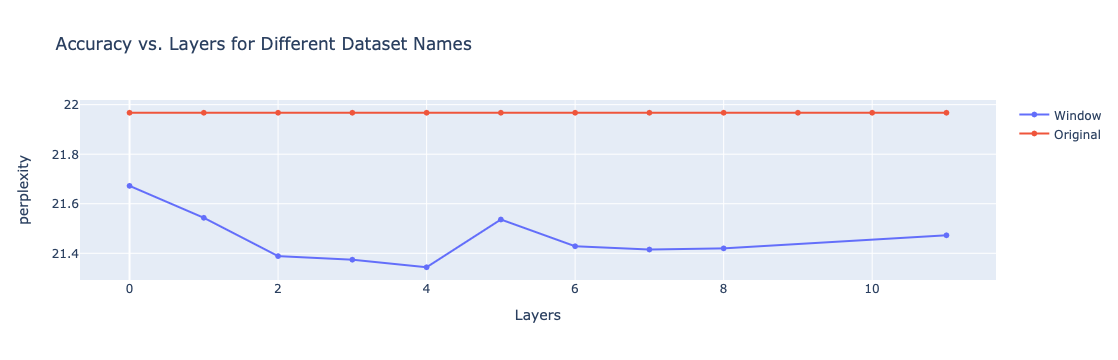

In [121]:
data = []
for name, group_data in baseline[(baseline['model_name']!='Original')].sort_values(by='layers').groupby('model_name'):
    layers = group_data['layers']
    accuracy = group_data[results_metric]
    data.append(go.Scatter(x=layers, y=accuracy, name=name))
layers = list(range(12))
accuracy = 21.967364

data.append(go.Scatter(x=layers, y=[accuracy for i in layers], name='Original'))
fig = go.Figure(data=data)
fig.update_layout(xaxis_title='Layers', yaxis_title=results_metric)
fig.update_layout(title='Accuracy vs. Layers for Different Dataset Names')
fig.show()

In [120]:
baseline[baseline['model_name']=='Original']

,model_name,dataset_name,layers,perplexity
1,Original,"[['', 'imdb']]",0,21.967364


In [89]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt

def EDA(dataset):
  print(dataset.info.description)

  # Display a few random samples
  print(dataset.shuffle(seed=42).select(range(5)))

  # Calculate basic statistics
  num_samples = len(dataset)
  print("Number of samples:", num_samples)

  for i in dataset.column_names:
      if type(dataset[i][0]) == str:
        print(f'Average word count in "{i}": {round(sum(list(map(len, dataset[i])))/len(list(map(len, dataset[i]))))}')

  # Vocabulary analysis
  vocabulary = set()
  for i in dataset.column_names:
    if type(dataset[i][0]) == str:
      for example in dataset[i]:
          vocabulary.update(example.split())
  vocab_size = len(vocabulary)
  print("Vocabulary size:", vocab_size)

  # Class distribution
  labels = pd.Series(dataset["label"])
  class_counts = labels.value_counts()
  print("Class distribution:")
  print(class_counts)

  


[nltk_data] Downloading package stopwords to /home/sasha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [100]:
from datasets import load_dataset
from tqdm import tqdm

# Define the list of GLU'E and SuperGLUE tasks and datasets you want to load
glue_tasks = ["wnli", "qqp", 'mrpc', 'sst2']

# Load the GLUE datasets
glue_datasets = {}
glue_skripts = {}
for task in tqdm(glue_tasks):
    dataset = load_dataset("glue", task, split="train")
    glue_datasets[task] = dataset

100%|████████████| 4/4 [00:03<00:00,  1.21it/s]


In [90]:
EDA(glue_datasets['qqp'])

GLUE, the General Language Understanding Evaluation benchmark
(https://gluebenchmark.com/) is a collection of resources for training,
evaluating, and analyzing natural language understanding systems.


Dataset({
    features: ['question1', 'question2', 'label', 'idx'],
    num_rows: 5
})
Number of samples: 363846
Average word count in "question1": 60
Average word count in "question2": 60
Vocabulary size: 222556
Class distribution:
0    229468
1    134378
Name: count, dtype: int64


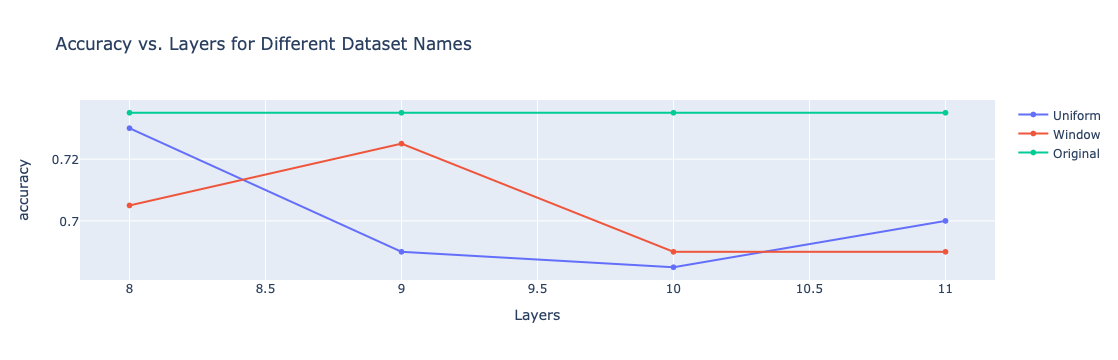

In [69]:
data = []
for name, group_data in baseline[(baseline['dataset_name']=='qqp')&(baseline['model_name']!='Original')].sort_values(by='layers').groupby('model_name'):
        layers = group_data['layers']
        accuracy = group_data[results_metric]
        data.append(go.Scatter(x=layers, y=accuracy, name=name))
layers = list(range(8,12))
accuracy = baseline[baseline['model_name']=='Original'][results_metric][0]
data.append(go.Scatter(x=layers, y=[accuracy for i in layers], name='Original'))
fig = go.Figure(data=data)
fig.update_layout(xaxis_title='Layers', yaxis_title=results_metric)
fig.update_layout(title='Accuracy vs. Layers for Different Dataset Names')

fig.show()

In [97]:
superglue_tasks = ["rte", 'wic']

# Load the SuperGLUE datasets
superglue_datasets = {}
superglue_skripts = {}
for task in superglue_tasks:
    dataset = load_dataset("super_glue", task, split="train")
    superglue_datasets[task] = dataset
EDA(superglue_datasets['rte'])

SuperGLUE (https://super.gluebenchmark.com/) is a new benchmark styled after
GLUE with a new set of more difficult language understanding tasks, improved
resources, and a new public leaderboard.

The Recognizing Textual Entailment (RTE) datasets come from a series of annual competitions
on textual entailment, the problem of predicting whether a given premise sentence entails a given
hypothesis sentence (also known as natural language inference, NLI). RTE was previously included
in GLUE, and we use the same data and format as before: We merge data from RTE1 (Dagan
et al., 2006), RTE2 (Bar Haim et al., 2006), RTE3 (Giampiccolo et al., 2007), and RTE5 (Bentivogli
et al., 2009). All datasets are combined and converted to two-class classification: entailment and
not_entailment. Of all the GLUE tasks, RTE was among those that benefited from transfer learning
the most, jumping from near random-chance performance (~56%) at the time of GLUE's launch to
85% accuracy (Liu et al., 2019c) at the ti

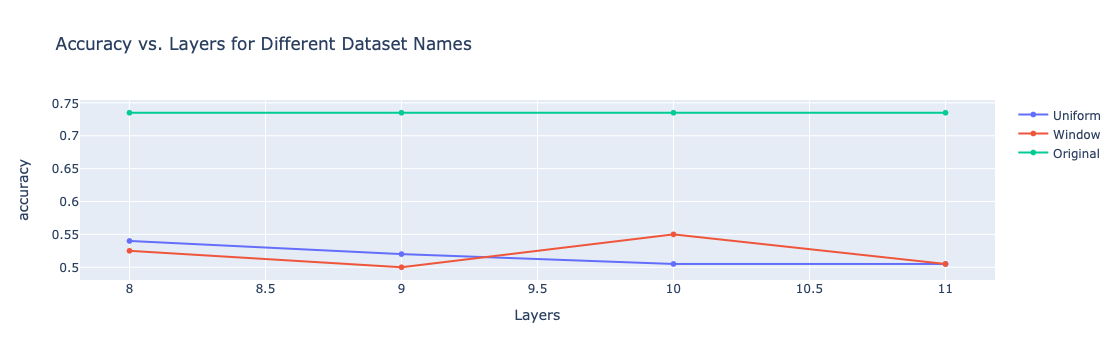

In [70]:
data = []
for name, group_data in baseline[(baseline['dataset_name']=='rte')&(baseline['model_name']!='Original')].sort_values(by='layers').groupby('model_name'):
        layers = group_data['layers']
        accuracy = group_data[results_metric]
        data.append(go.Scatter(x=layers, y=accuracy, name=name))
layers = list(range(8,12))
accuracy = baseline[baseline['model_name']=='Original'][results_metric][0]
data.append(go.Scatter(x=layers, y=[accuracy for i in layers], name='Original'))
fig = go.Figure(data=data)
fig.update_layout(xaxis_title='Layers', yaxis_title=results_metric)
fig.update_layout(title='Accuracy vs. Layers for Different Dataset Names')

In [92]:
EDA(glue_datasets['wnli'])

GLUE, the General Language Understanding Evaluation benchmark
(https://gluebenchmark.com/) is a collection of resources for training,
evaluating, and analyzing natural language understanding systems.


Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 5
})
Number of samples: 635
Average word count in "sentence1": 105
Average word count in "sentence2": 44
Vocabulary size: 1673
Class distribution:
0    323
1    312
Name: count, dtype: int64


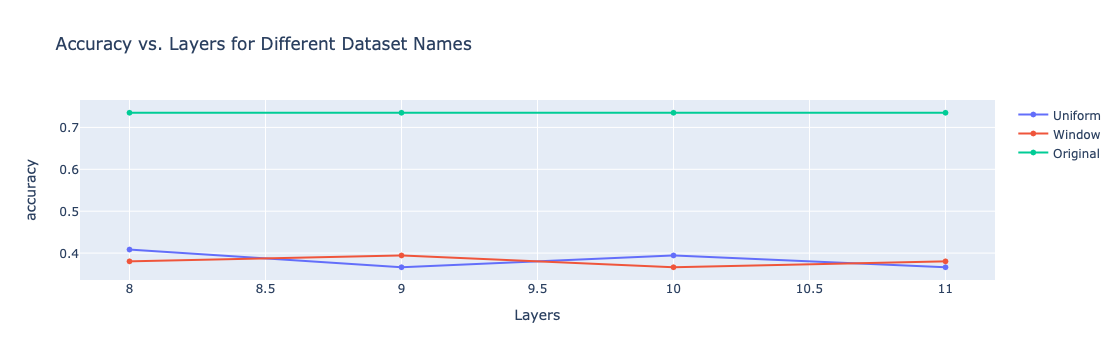

In [71]:

data = []
for name, group_data in baseline[(baseline['dataset_name']=='wnli')&(baseline['model_name']!='Original')].sort_values(by='layers').groupby('model_name'):
        layers = group_data['layers']
        accuracy = group_data[results_metric]
        data.append(go.Scatter(x=layers, y=accuracy, name=name))
layers = list(range(8,12))
accuracy = baseline[baseline['model_name']=='Original'][results_metric][0]
data.append(go.Scatter(x=layers, y=[accuracy for i in layers], name='Original'))
fig = go.Figure(data=data)
fig.update_layout(xaxis_title='Layers', yaxis_title=results_metric)
fig.update_layout(title='Accuracy vs. Layers for Different Dataset Names')

SuperGLUE (https://super.gluebenchmark.com/) is a new benchmark styled after
GLUE with a new set of more difficult language understanding tasks, improved
resources, and a new public leaderboard.

The Word-in-Context (WiC, Pilehvar and Camacho-Collados, 2019) dataset supports a word
sense disambiguation task cast as binary classification over sentence pairs. Given two sentences and a
polysemous (sense-ambiguous) word that appears in both sentences, the task is to determine whether
the word is used with the same sense in both sentences. Sentences are drawn from WordNet (Miller,
1995), VerbNet (Schuler, 2005), and Wiktionary. We follow the original work and evaluate using
accuracy.
Dataset({
    features: ['word', 'sentence1', 'sentence2', 'start1', 'start2', 'end1', 'end2', 'idx', 'label'],
    num_rows: 5
})
Number of samples: 5428
Average word count in "word": 5
Average word count in "sentence1": 37
Average word count in "sentence2": 39
Vocabulary size: 10785
Class distribution:
0    2

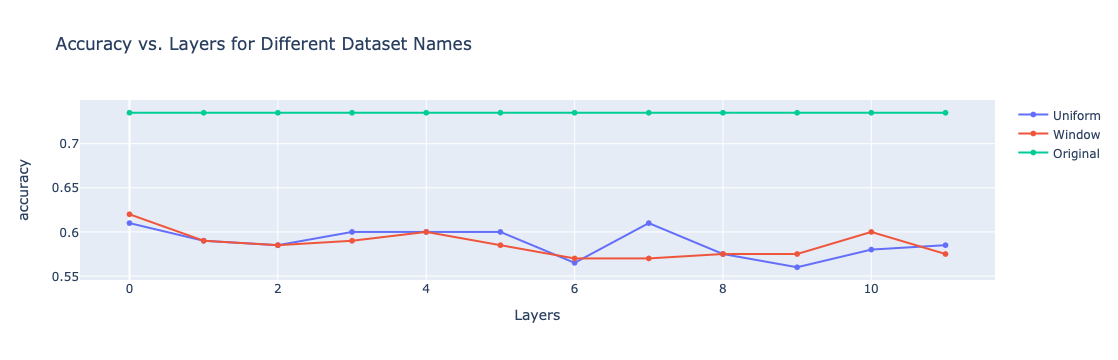

In [99]:
EDA(superglue_datasets['wic'])
data = []
for name, group_data in baseline[(baseline['dataset_name']=='wic')&(baseline['model_name']!='Original')].sort_values(by='layers').groupby('model_name'):
        layers = group_data['layers']
        accuracy = group_data[results_metric]
        data.append(go.Scatter(x=layers, y=accuracy, name=name))
layers = list(range(0,12))
accuracy = baseline[baseline['model_name']=='Original'][results_metric][0]
data.append(go.Scatter(x=layers, y=[accuracy for i in layers], name='Original'))
fig = go.Figure(data=data)
fig.update_layout(xaxis_title='Layers', yaxis_title=results_metric)
fig.update_layout(title='Accuracy vs. Layers for Different Dataset Names')


GLUE, the General Language Understanding Evaluation benchmark
(https://gluebenchmark.com/) is a collection of resources for training,
evaluating, and analyzing natural language understanding systems.


Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 5
})
Number of samples: 3668
Average word count in "sentence1": 118
Average word count in "sentence2": 119
Vocabulary size: 15168
Class distribution:
1    2474
0    1194
Name: count, dtype: int64


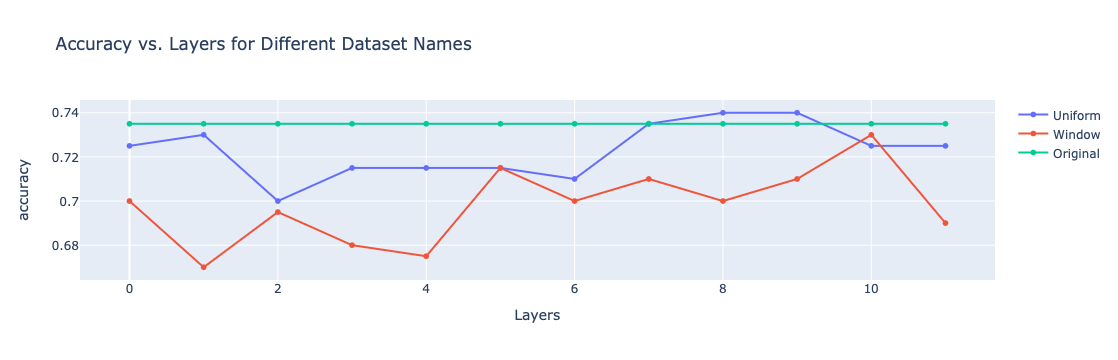

In [96]:
EDA(glue_datasets['mrpc'])
data = []
for name, group_data in baseline[(baseline['dataset_name']=='mrpc')&(baseline['model_name']!='Original')].sort_values(by='layers').groupby('model_name'):
        layers = group_data['layers']
        accuracy = group_data[results_metric]
        data.append(go.Scatter(x=layers, y=accuracy, name=name))
layers = list(range(0,12))
accuracy = baseline[baseline['model_name']=='Original'][results_metric][0]
data.append(go.Scatter(x=layers, y=[accuracy for i in layers], name='Original'))
fig = go.Figure(data=data)
fig.update_layout(xaxis_title='Layers', yaxis_title=results_metric)
fig.update_layout(title='Accuracy vs. Layers for Different Dataset Names')


GLUE, the General Language Understanding Evaluation benchmark
(https://gluebenchmark.com/) is a collection of resources for training,
evaluating, and analyzing natural language understanding systems.


Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 5
})
Number of samples: 67349
Average word count in "sentence": 54
Vocabulary size: 14816
Class distribution:
1    37569
0    29780
Name: count, dtype: int64


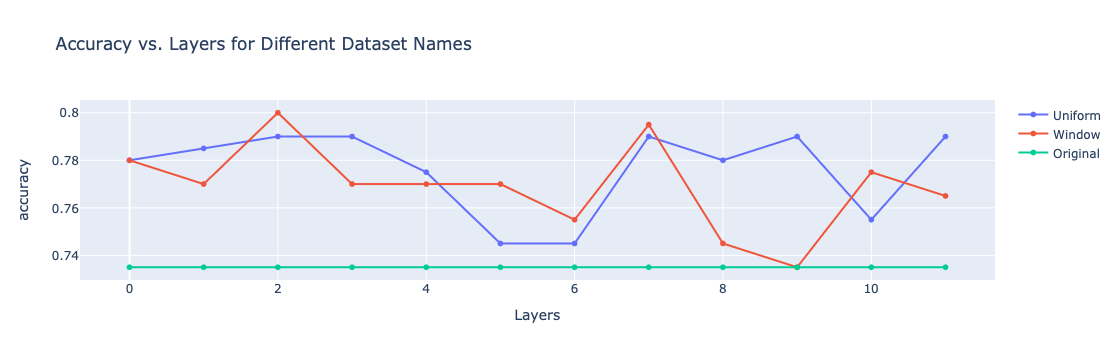

In [102]:
EDA(glue_datasets['sst2'])
data = []
for name, group_data in baseline[(baseline['dataset_name']=='sst2')&(baseline['model_name']!='Original')].sort_values(by='layers').groupby('model_name'):
        layers = group_data['layers']
        accuracy = group_data[results_metric]
        data.append(go.Scatter(x=layers, y=accuracy, name=name))
layers = list(range(0,12))
accuracy = baseline[baseline['model_name']=='Original'][results_metric][0]
data.append(go.Scatter(x=layers, y=[accuracy for i in layers], name='Original'))
fig = go.Figure(data=data)
fig.update_layout(xaxis_title='Layers', yaxis_title=results_metric)
fig.update_layout(title='Accuracy vs. Layers for Different Dataset Names')
